In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [33]:
def load_images(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    images = []
    gray_images = []
    
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_images.append(gray)
    
    return images, gray_images

In [34]:
def extract_sift_features(gray_images):
    sift = cv2.SIFT_create()
    
    features = []
    for i, gray_img in enumerate(gray_images):
        # detectAndCompute для поиска ключевых точек и дескрипторов
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        features.append((keypoints, descriptors))
    
    return features

In [35]:
def select_reference_image(features):
    # Подсчет количества ключевых точек для каждого изображения и выбор изображения с максимальным числом точек
    num_keypoints = [len(kp) for kp, _ in features]
    ref_idx = np.argmax(num_keypoints)
    
    print(f"Опорное изображение: {ref_idx+1} ({num_keypoints[ref_idx]} ключевых точек)")
    return ref_idx

In [36]:
def match_features(desc1, desc2, ratio=0.75):
    # Использование BFMatcher с L2 нормой для SIFT
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    
    # Поиск двух ближайших соседей для каждого дескриптора
    matches = bf.knnMatch(desc1, desc2, k=2)
    
    # Применение Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio * n.distance:
                good_matches.append(m)
    
    return good_matches

In [37]:
def estimate_homography(kp1, kp2, matches, min_matches=10):
    if len(matches) < min_matches:
        print(f"Недостаточно совпадений: {len(matches)} < {min_matches}")
        return None, None
    
    # Извлечение координат совпадающих точек
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Поиск гомографии с использованием RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    if H is not None:
        matches_mask = mask.ravel().tolist()
        inliers = sum(matches_mask)
        print(f"Найдено {inliers}/{len(matches)} inliers")
        
        if inliers < min_matches:
            return None, None
    
    return H, mask

In [38]:
def warp_and_blend(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Определение углов первого изображения
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    
    # Трансформация углов с помощью гомографии
    corners1_transformed = cv2.perspectiveTransform(corners1, H)
    
    # Объединение углов обоих изображений
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    all_corners = np.concatenate((corners1_transformed, corners2), axis=0)
    
    # Вычисление размера выходного холста
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    # Матрица сдвига для размещения результата
    translation = np.array([[1, 0, -x_min],
                           [0, 1, -y_min],
                           [0, 0, 1]])
    
    # Применение проективного преобразования к первому изображению
    output_size = (x_max - x_min, y_max - y_min)
    img1_warped = cv2.warpPerspective(img1, translation.dot(H), output_size)

    # Создаем холст для результата
    result = np.zeros((y_max - y_min, x_max - x_min, 3), dtype=np.uint8)
    result = img1_warped.copy()
    
    # Вставка второго изображения с усреднением в зоне перекрытия
    y_offset = -y_min
    x_offset = -x_min
    
    # Области изображений
    roi = result[y_offset:y_offset+h2, x_offset:x_offset+w2]
    
    # Маски для смешивания
    mask1 = (img1_warped[y_offset:y_offset+h2, x_offset:x_offset+w2] > 0).astype(np.float32)
    mask2 = (img2 > 0).astype(np.float32)
    
    # Усреднение пикселей в зоне перекрытия
    overlap_mask = (mask1[:,:,0] > 0) & (mask2[:,:,0] > 0)
    
    # Копирование второго изображения
    roi_copy = roi.copy()
    roi_copy[mask2[:,:,0] > 0] = img2[mask2[:,:,0] > 0]
    
    # Усреднение в зоне перекрытия
    if overlap_mask.any():
        for c in range(3):
            blended = (roi[:,:,c].astype(np.float32) + img2[:,:,c].astype(np.float32)) / 2
            roi_copy[:,:,c][overlap_mask] = blended[overlap_mask].astype(np.uint8)
    
    result[y_offset:y_offset+h2, x_offset:x_offset+w2] = roi_copy
    
    return result

In [39]:
def crop_black_borders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Поиск ненулевых пикселей
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    # Поиск контуров
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Получение bounding box самого большого контура
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        
        # Обрезка изображения
        cropped = image[y:y+h, x:x+w]
        return cropped
    
    return image

In [40]:
def create_panorama(images, features, ref_idx):
    # Опорное изображение
    panorama = images[ref_idx].copy()
    panorama_kp, panorama_desc = features[ref_idx]
    
    # Отслеживание использованных изображений
    used = {ref_idx}
    
    # Итеративное добавление изображений
    while len(used) < len(images):
        best_match_count = 0
        best_idx = -1
        best_matches = None
        best_H = None
        
        # Поиск изображения с наибольшим количеством совпадений с текущей панорамой
        for i in range(len(images)):
            if i in used:
                continue
            
            kp_i, desc_i = features[i]
            
            # Сопоставление дескрипторов
            matches = match_features(desc_i, panorama_desc)
            
            if len(matches) > best_match_count:
                # Оценка гомографии
                H, mask = estimate_homography(kp_i, panorama_kp, matches)
                
                if H is not None:
                    best_match_count = len(matches)
                    best_idx = i
                    best_matches = matches
                    best_H = H
        
        # Если не найдено подходящих изображений
        if best_idx == -1:
            print(f"Не удалось найти подходящее изображение. Использовано {len(used)}/{len(images)}")
            break
        
        print(f"\nДобавление изображения {best_idx+1} ({best_match_count} совпадений)")
        
        # Применение трансформации и сшивка
        panorama = warp_and_blend(images[best_idx], panorama, best_H)
        
        # Обновление признаков панорамы
        gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        panorama_kp, panorama_desc = sift.detectAndCompute(gray_panorama, None)
        
        # Добавление в список использованных
        used.add(best_idx)
        
        print(f"Панорама обновлена. Размер: {panorama.shape[1]}x{panorama.shape[0]}")
    
    return panorama

In [41]:
def process_map_folder(folder_path, output_path):
    print(f"Обработка папки: {folder_path}")
    # Загрузка данных
    images, gray_images = load_images(folder_path)
    
    if len(images) == 0:
        print("Ошибка: изображения не найдены")
        return None
    
    # Извлечение признаков SIFT
    features = extract_sift_features(gray_images)
    
    # Выбор опорного изображения
    ref_idx = select_reference_image(features)
    
    # Создание панорамы
    panorama = create_panorama(images, features, ref_idx)
    
    # Удаление черных границ
    panorama = crop_black_borders(panorama)
    
    # Сохранение результата
    cv2.imwrite(output_path, panorama)
    print(f"\nПанорама сохранена: {output_path}")
    print(f"Итоговый размер: {panorama.shape[1]}x{panorama.shape[0]}")
    
    return panorama

In [42]:
sample_data_dir = 'sample_data'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
map_folders = ['map1', 'map2', 'map3']

panoramas = {}

In [43]:
# Обработка map1
folder_path = os.path.join(sample_data_dir, 'map1')
output_path = os.path.join(output_dir, 'panorama_map1.jpg')
panoramas['map1'] = process_map_folder(folder_path, output_path)

Обработка папки: sample_data/map1
Опорное изображение: 1 (18268 ключевых точек)
Найдено 4/65 inliers
Найдено 7/37 inliers
Найдено 7753/7782 inliers

Добавление изображения 4 (7782 совпадений)
Панорама обновлена. Размер: 1000x1536
Найдено 6/70 inliers
Найдено 6/45 inliers
Найдено 5/42 inliers
Найдено 687/726 inliers
Найдено 6189/6219 inliers

Добавление изображения 9 (6219 совпадений)
Панорама обновлена. Размер: 1536x1536
Найдено 6/58 inliers
Найдено 1707/1745 inliers
Найдено 2725/2748 inliers
Найдено 7591/7605 inliers
Найдено 8267/8292 inliers

Добавление изображения 10 (8292 совпадений)
Панорама обновлена. Размер: 1612x1536
Найдено 6/62 inliers
Найдено 2335/2366 inliers
Найдено 8616/8621 inliers

Добавление изображения 5 (8621 совпадений)
Панорама обновлена. Размер: 2036x1536
Найдено 6/57 inliers
Найдено 5669/5695 inliers
Найдено 10382/10393 inliers

Добавление изображения 6 (10393 совпадений)
Панорама обновлена. Размер: 2036x1536
Найдено 6/53 inliers
Найдено 8464/8484 inliers
Найдено

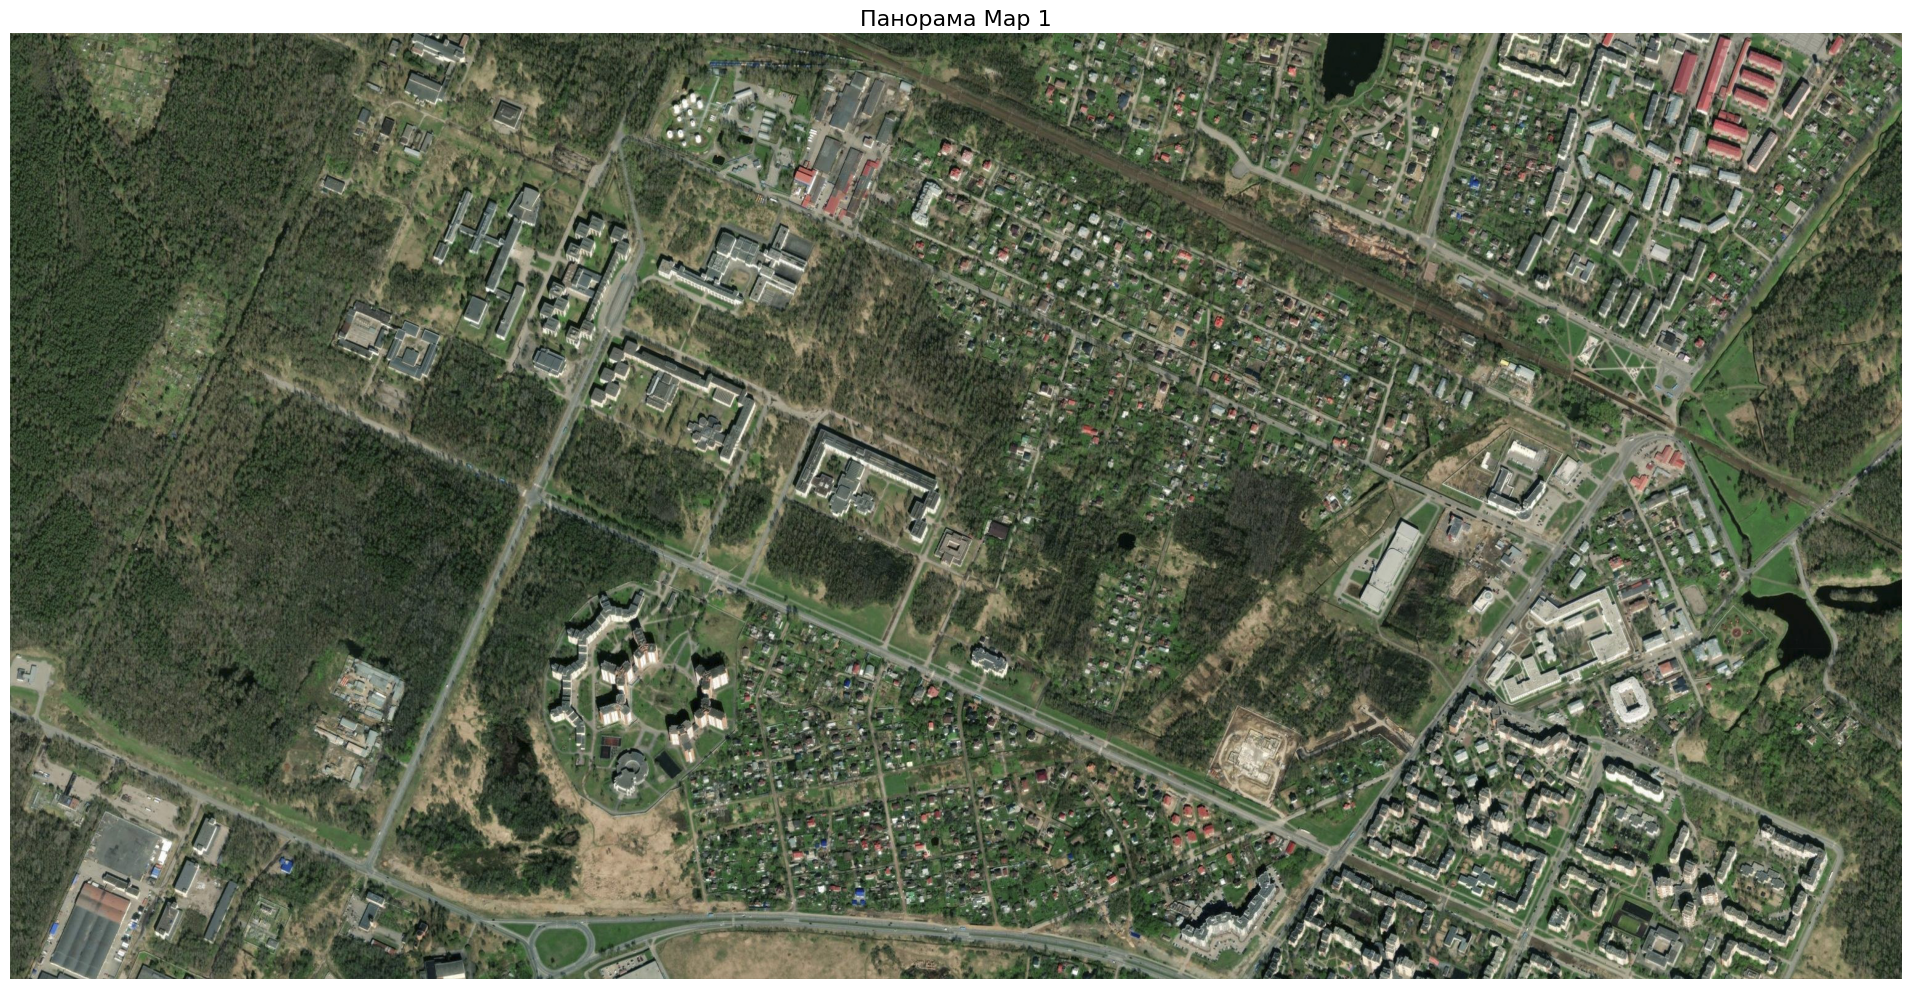

In [44]:
# Визуализация результата Map 1
if panoramas['map1'] is not None:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(panoramas['map1'], cv2.COLOR_BGR2RGB))
    plt.title('Панорама Map 1', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [45]:
# Обработка map2
folder_path = os.path.join(sample_data_dir, 'map2')
output_path = os.path.join(output_dir, 'panorama_map2.jpg')
panoramas['map2'] = process_map_folder(folder_path, output_path)

Обработка папки: sample_data/map2
Опорное изображение: 8 (23204 ключевых точек)
Найдено 4691/4733 inliers
Найдено 8411/8443 inliers
Найдено 9996/10023 inliers

Добавление изображения 4 (10023 совпадений)
Панорама обновлена. Размер: 1373x1375
Найдено 4586/4632 inliers
Найдено 10414/10435 inliers

Добавление изображения 3 (10435 совпадений)
Панорама обновлена. Размер: 1490x1440
Найдено 5442/5487 inliers
Найдено 8090/8131 inliers

Добавление изображения 5 (8131 совпадений)
Панорама обновлена. Размер: 1535x1515
Найдено 5373/5409 inliers
Найдено 7538/7597 inliers

Добавление изображения 6 (7597 совпадений)
Панорама обновлена. Размер: 1535x2053
Найдено 5364/5396 inliers
Найдено 7663/7707 inliers

Добавление изображения 7 (7707 совпадений)
Панорама обновлена. Размер: 1535x2053
Найдено 5358/5393 inliers

Добавление изображения 1 (5393 совпадений)
Панорама обновлена. Размер: 1535x2713
Найдено 8913/8972 inliers

Добавление изображения 2 (8972 совпадений)
Панорама обновлена. Размер: 1535x2804

Па

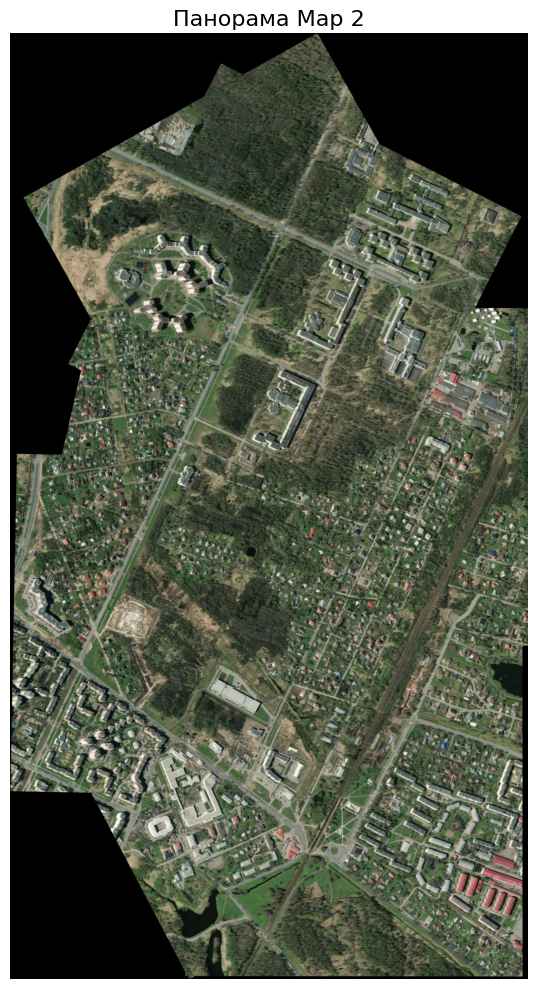

In [46]:
# Визуализация результата Map 2
if panoramas['map2'] is not None:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(panoramas['map2'], cv2.COLOR_BGR2RGB))
    plt.title('Панорама Map 2', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [47]:
# Обработка map3
folder_path = os.path.join(sample_data_dir, 'map3')
output_path = os.path.join(output_dir, 'panorama_map3.jpg')
panoramas['map3'] = process_map_folder(folder_path, output_path)

Обработка папки: sample_data/map3
Опорное изображение: 7 (4421 ключевых точек)
Найдено 340/341 inliers
Найдено 1541/1549 inliers

Добавление изображения 2 (1549 совпадений)
Панорама обновлена. Размер: 889x687
Найдено 503/504 inliers
Найдено 1227/1231 inliers
Найдено 1258/1267 inliers

Добавление изображения 6 (1267 совпадений)
Панорама обновлена. Размер: 1300x739
Найдено 500/501 inliers
Найдено 748/753 inliers
Найдено 952/956 inliers
Найдено 1306/1308 inliers
Найдено 1711/1715 inliers

Добавление изображения 8 (1715 совпадений)
Панорама обновлена. Размер: 1355x896
Найдено 501/502 inliers
Найдено 737/742 inliers
Найдено 984/984 inliers
Найдено 1372/1376 inliers

Добавление изображения 5 (1376 совпадений)
Панорама обновлена. Размер: 1355x923
Найдено 658/658 inliers
Найдено 726/730 inliers
Найдено 949/952 inliers

Добавление изображения 4 (952 совпадений)
Панорама обновлена. Размер: 1575x923
Найдено 659/660 inliers
Найдено 836/842 inliers

Добавление изображения 3 (842 совпадений)
Панорам

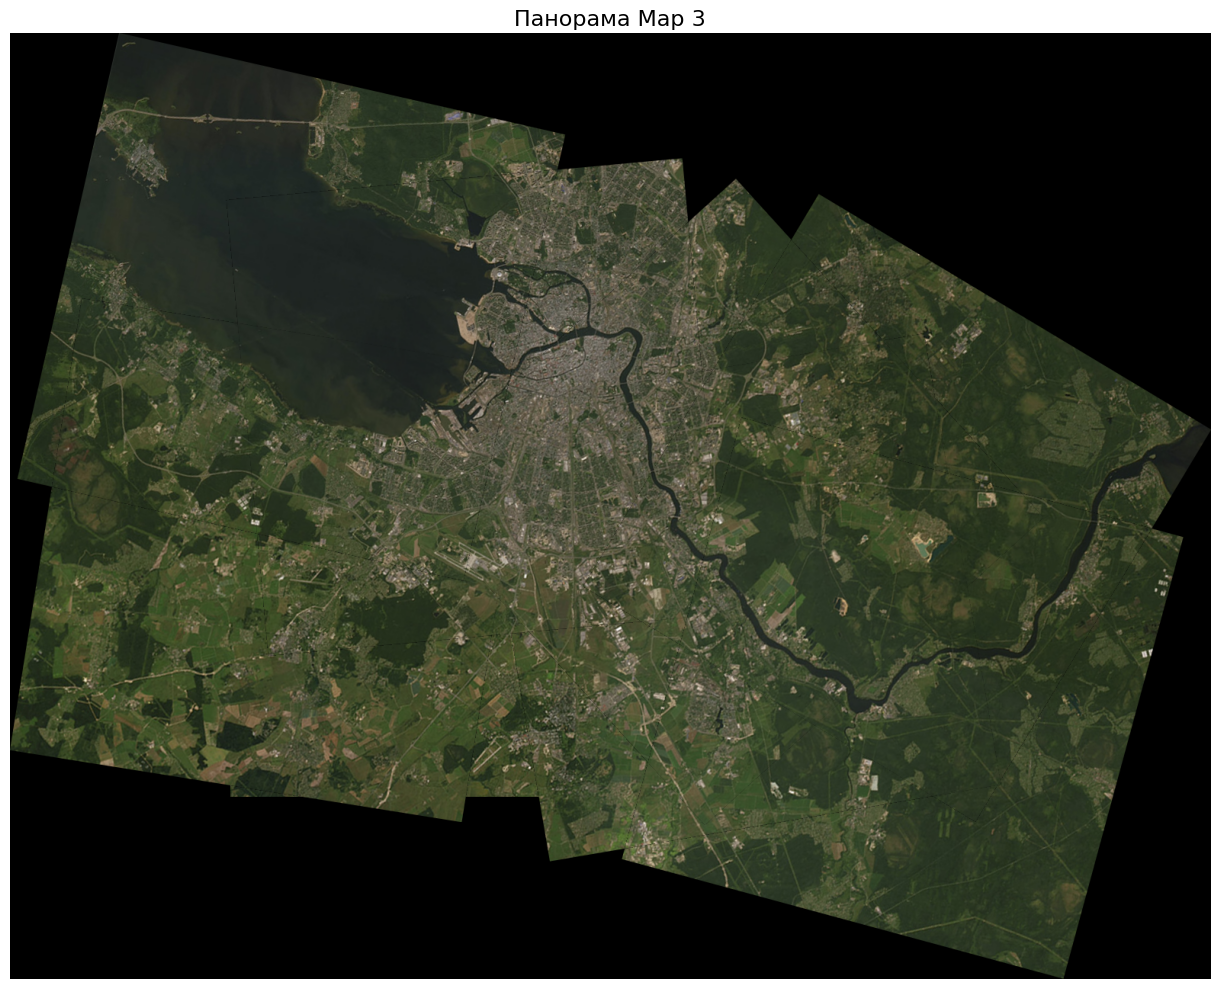

In [48]:
# Визуализация результата Map 3
if panoramas['map3'] is not None:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(panoramas['map3'], cv2.COLOR_BGR2RGB))
    plt.title('Панорама Map 3', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()